# Projet Python Avancé : **Analyse d’article de presse**

**Abdeljabbar RACHID**

# Chargement des données

Décompresser le fichier Articles.zip contenant les articles.

In [ ]:
import zipfile
import os

zip_path = "Articles.zip"
extract_path = "/content/Articles"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Classification des articles par catégorie
Lire les fichiers d'articles extraits, les classer en trois catégories (Economie, Science, Sport) en fonction de leur nom de fichier, et compter le  nombre d'articles dans chaque catégorie pour vérifier qu’il n’y a pas de biais d’échantillonnage. Les articles sont également analysés pour détecter d'éventuelles anomalies.

In [ ]:
import pandas as pd
import numpy as np

anomalie = []
Eco = []
Sciences = []
Sport = []

articles_path = "./Articles/Articles"
Articles = os.listdir(articles_path)

for article in list(set(Articles)):
    chemin = os.path.join(articles_path, article)

    with open(chemin, 'r', encoding='utf-8') as file:
        content = file.read()
        parties = content.split("\n\n")

        if len(parties) >= 3:
            titre = parties[0].strip()
            description = parties[1].strip()
            article_content = "\n\n".join(part.strip() for part in parties[2:])
            data_entry = {"Titre": titre, "Description": description, "Article": article_content}

            if "economie" in article:
                data_entry['Type'] = 'Economie'
                Eco.append(data_entry)
            elif "science" in article:
                data_entry['Type'] = 'Science'
                Sciences.append(data_entry)
            elif "sport" in article:
                data_entry['Type'] = 'Sport'
                Sport.append(data_entry)
        else:
            anomalie.append(article)


Eco_df = pd.DataFrame(Eco)
Sciences_df = pd.DataFrame(Sciences)
Sport_df = pd.DataFrame(Sport)

print("Articles classés dans 'Economie':", len(Eco_df))
print("Articles classés dans 'Science':", len(Sciences_df))
print("Articles classés dans 'Sport':", len(Sport_df))
print("Articles avec anomalie:", len(anomalie))

Articles classés dans 'Economie': 1196
Articles classés dans 'Science': 1207
Articles classés dans 'Sport': 1278
Articles avec anomalie: 0


In [ ]:
len(Articles)

3681

* La base de données semble **suffisamment équilibrée**, ce qui garantit une évaluation plus juste des performances du modèle sans **sur-apprentissage** sur une classe dominante.

# Combinaison les DataFrames
On fusionne les trois DataFrames (`Eco_df`, `Sciences_df`, `Sport_df`) en un seul DataFrame `df` pour faciliter les analyses ultérieures.

In [ ]:
df = pd.concat([Eco_df, Sciences_df, Sport_df], ignore_index=True)

# Tokenisation du texte de chaque élément d'article
Appliquons la tokenisation sur les colonnes `Titre`, `Description`, et `Article` du DataFrame. Les tokens sont ensuite stockés dans de nouvelles colonnes (`Tokens_Titre`, `Tokens_Description`, `Tokens_Article`).

In [ ]:
from nltk.tokenize import RegexpTokenizer

def tokenizer(texte):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(texte.lower())
    return tokens

# tokenisation des colonnes "Titre", "Description" et "Article"
df['Tokens_Titre'] = df['Titre'].apply(tokenizer)
df['Tokens_Description'] = df['Description'].apply(tokenizer)
df['Tokens_Article'] = df['Article'].apply(tokenizer)

# Calcul du nombre de mots et visualisation
Calculer le nombre de mots dans chaque colonne tokenisée (`Titre`, `Description`, `Article`) et visualiser la moyenne du nombre de mots par type d'article à l'aide d'un graphique en barres.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


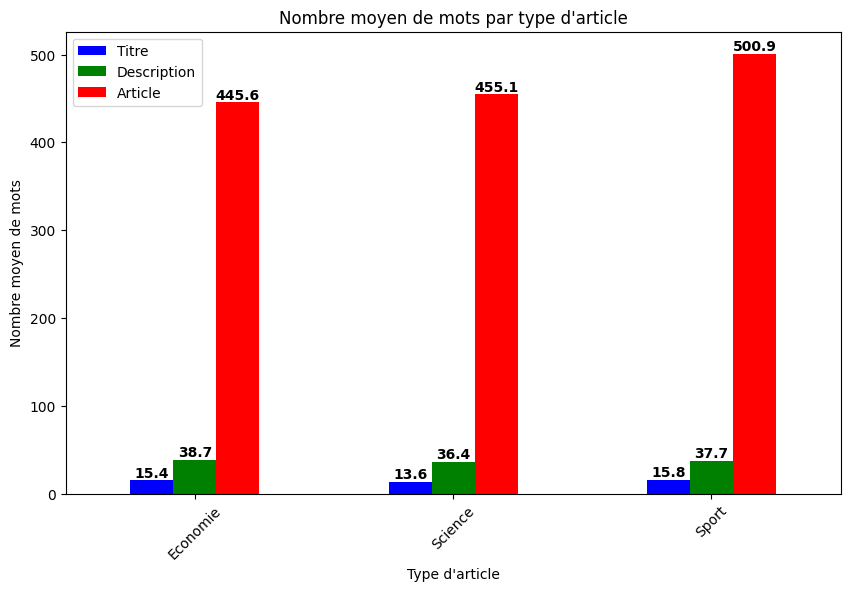

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')

# Calcul du nombre de mots
df['Nombre_Mots_Titre'] = df['Tokens_Titre'].apply(len)
df['Nombre_Mots_Description'] = df['Tokens_Description'].apply(len)
df['Nombre_Mots_Article'] = df['Tokens_Article'].apply(len)

# Calcul de la moyenne du nombre de mots par type d'article
moyenne_mots = df.groupby('Type')[['Nombre_Mots_Titre', 'Nombre_Mots_Description', 'Nombre_Mots_Article']].mean()

ax = moyenne_mots.plot(kind='bar', color=['blue', 'green', 'red'], figsize=(10, 6))
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

plt.xlabel('Type d\'article')
plt.ylabel('Nombre moyen de mots')
plt.title('Nombre moyen de mots par type d\'article')
plt.xticks(rotation=45)
plt.legend(['Titre', 'Description', 'Article'])
plt.show()

visualiser le nombre moyen de mots et la richesse lexicale par type d'article (`Economie`, `Science`, `Sport`) pour chaque élément `Titre`,` Description`, et `Article`.

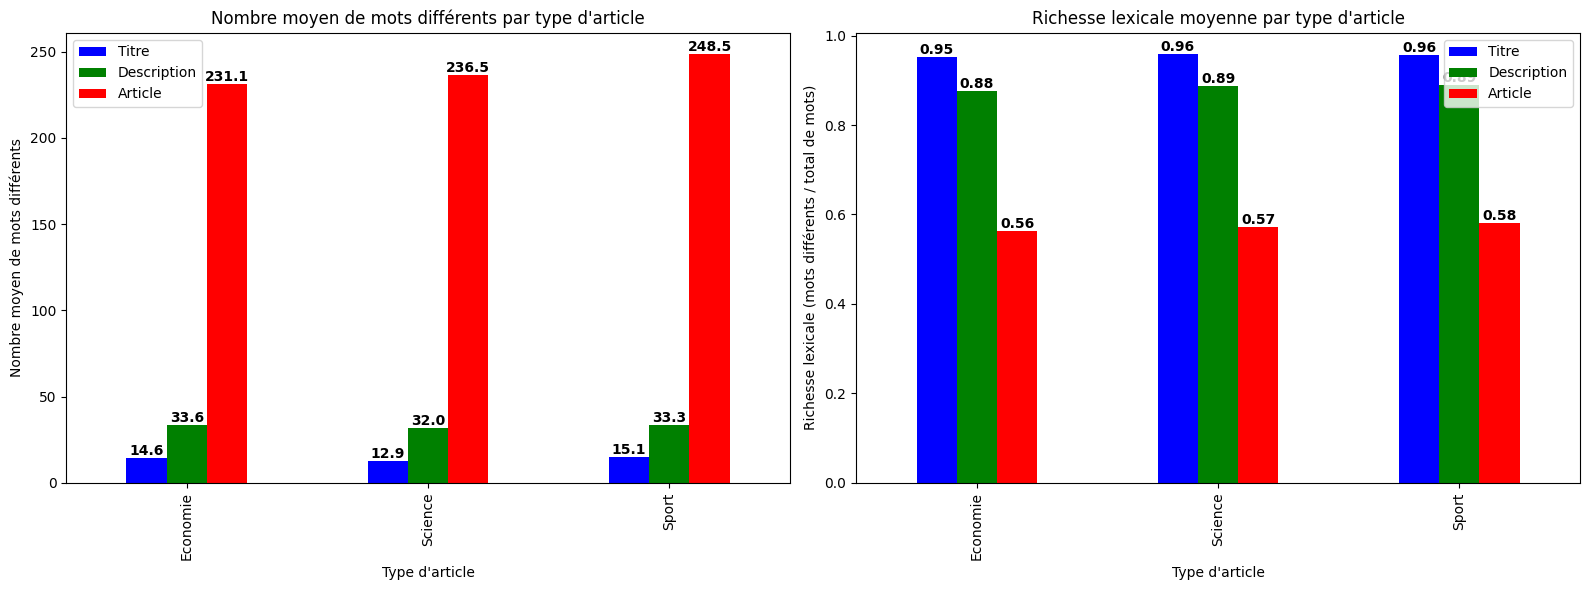

In [ ]:
# Calcul du nombre de mots différents
df['Mots_Differents_Titre'] = df['Tokens_Titre'].apply(lambda x: len(set(x)))
df['Mots_Differents_Description'] = df['Tokens_Description'].apply(lambda x: len(set(x)))
df['Mots_Differents_Article'] = df['Tokens_Article'].apply(lambda x: len(set(x)))

# Calcul de la richesse lexicale (mots différents / total de mots)
df['Richesse_Titre'] = df['Mots_Differents_Titre'] / df['Nombre_Mots_Titre']
df['Richesse_Description'] = df['Mots_Differents_Description'] / df['Nombre_Mots_Description']
df['Richesse_Article'] = df['Mots_Differents_Article'] / df['Nombre_Mots_Article']

# Moyennes par type d'article
moyenne_df = df.groupby('Type')[[
    'Mots_Differents_Titre', 'Mots_Differents_Description', 'Mots_Differents_Article',
    'Richesse_Titre', 'Richesse_Description', 'Richesse_Article'
]].mean()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = moyenne_df[['Mots_Differents_Titre', 'Mots_Differents_Description', 'Mots_Differents_Article']].plot(
    kind='bar', color=['blue', 'green', 'red'], ax=axes[0])
ax1.set_title("Nombre moyen de mots différents par type d'article")
ax1.set_xlabel("Type d'article")
ax1.set_ylabel("Nombre moyen de mots différents")
ax1.legend(['Titre', 'Description', 'Article'])
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.1f', label_type='edge', fontsize=10, fontweight='bold', color='black')

ax2 = moyenne_df[['Richesse_Titre', 'Richesse_Description', 'Richesse_Article']].plot(
    kind='bar', color=['blue', 'green', 'red'], ax=axes[1])
ax2.set_title("Richesse lexicale moyenne par type d'article")
ax2.set_xlabel("Type d'article")
ax2.set_ylabel("Richesse lexicale (mots différents / total de mots)")
ax2.legend(['Titre', 'Description', 'Article'])
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.2f', label_type='edge', fontsize=10, fontweight='bold', color='black')

plt.tight_layout()
plt.show()

Les résultats montrent que les articles entiers contiennent le plus grand nombre de mots différents, mais leur richesse lexicale est plus faible en raison des répétitions. En revanche, les titres et descriptions, bien plus courts, affichent une richesse lexicale élevée, indiquant une plus grande diversité de vocabulaire en proportion de leur longueur. Cette tendance est similaire pour les articles d'économie, de science et de sport, sans différences notables entre ces catégories.

# Analyse des mots les plus fréquents

Identifier les mots les plus fréquents à l'aide de Counter ensuite Suppression des stopwords afin de nettoyer les textes du mots courants non informatifs.



In [ ]:
from collections import Counter

# Fonction pour obtenir les mots les plus fréquents
def mots_plus_frequents(tokens_list, n=30):
    return Counter(tokens_list).most_common(n)

# Affichage des 30 mots les plus fréquents pour chaque type d'article
for type_article in df['Type'].unique():
    df_filtered = df[df['Type'] == type_article]

    tokens_titre = df_filtered['Tokens_Titre'].sum()
    tokens_description = df_filtered['Tokens_Description'].sum()
    tokens_article = df_filtered['Tokens_Article'].sum()

    print(f"\n-------- Mots les plus fréquents pour : {type_article} --------")

    print("\n** Titre ** :")
    print(mots_plus_frequents(tokens_titre))

    print("\n** Description ** :")
    print(mots_plus_frequents(tokens_description))

    print("\n** Article ** :")
    print(mots_plus_frequents(tokens_article))


-------- Mots les plus fréquents pour : Economie --------

** Titre ** :
[('de', 949), ('la', 658), ('le', 535), ('les', 469), ('l', 414), ('à', 399), ('en', 340), ('des', 321), ('d', 292), ('du', 241), ('et', 238), ('un', 224), ('pour', 217), ('sur', 157), ('au', 133), ('une', 131), ('budget', 130), ('dans', 117), ('2025', 114), ('france', 105), ('par', 95), ('a', 91), ('est', 73), ('plus', 69), ('gouvernement', 67), ('son', 64), ('ce', 62), ('pas', 60), ('paris', 54), ('grève', 54)]

** Description ** :
[('de', 2839), ('la', 1507), ('l', 1258), ('le', 1237), ('les', 971), ('à', 949), ('des', 880), ('d', 872), ('et', 727), ('en', 707), ('du', 592), ('une', 535), ('a', 529), ('un', 490), ('pour', 490), ('sur', 445), ('ce', 432), ('dans', 394), ('qui', 348), ('au', 335), ('par', 320), ('que', 218), ('est', 213), ('plus', 171), ('ont', 168), ('s', 163), ('se', 159), ('avec', 149), ('son', 148), ('ses', 146)]

** Article ** :
[('de', 29481), ('la', 15430), ('le', 12782), ('l', 12408), ('

L’analyse révèle que les mots les plus fréquents sont à la fois des mots outils (tels que de, la, le, les) et des termes propres à chaque domaine. En économie, on observe la présence de budget, gouvernement, grève ; en science, des mots comme lune, espace, terre ; et en sport, des mentions de 2024, Paris, JO, jeux. Ces résultats traduisent fidèlement les thématiques abordées.

Il est donc nécessaire d’harmoniser les étapes de nettoyage et de suppression des stopwords. Une liste de stopwords personnalisée, adaptée au français journalistique, devrait également être envisagée — en incluant notamment les formes élidées comme l’, d’, etc.

In [ ]:
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

# Chargement des stop-words de nltk
stop_words_nltk = set(stopwords.words('french'))


stopword_file_path = './stopword.txt'

# Chargement des stop-words du fichier "stopword.txt" du TP
with open(stopword_file_path, 'r', encoding='utf-8') as file:
    stop_words_extra = file.read().split(',')

# Liste élargie de mots usuels
mots_supplémentaires = {
    "faut", "fait","faire", "encore", "puis", "donc", "ainsi", "or", "trop", "très", "comme","avoir", "être", "cette", "cet", "ce", "ces", "cela", "ça", "c'", "là", "où",
    "parce", "que", "quoi", "quel", "quelle", "quelles", "quels", "lequel", "laquelle", "lesquels", "lesquelles", "dont", "chez", "lorsque", "lorsqu'", "afin", "alors",
    "si", "mais", "car", "même", "entre", "tandis", "toujours", "trop", "peu", "bien","mal", "déjà", "encore", "souvent", "jamais", "quelque", "quelques", "plusieurs",
    "chaque", "aucun", "aucune", "toute", "toutes", "tous", "certain", "certaine","certains", "certaines", "sans", "avec", "vers", "sur", "sous", "dans", "devant",
    "derrière", "pendant", "avant", "après", "depuis", "ainsi", "donc", "or", "cependant","néanmoins", "pourtant", "toutefois", "autrement", "sinon", "enfin", "bref", "puisque",
    "voilà", "par", "contre", "dessus", "dessous", "dessus", "autour", "auprès", "d'après","quant", "selon", "sauf", "excepté", "hors", "mis", "à", "de", "du", "des","deux","trois", "au",
    "aux", "et", "ou", "ni", "soit", "car", "mais", "donc", "or", "et", "ainsi", "voire","non", "oui", "si", "c'", "est", "était", "étaient", "serait", "seraient", "seront","années",
    "sera", "seras", "serions", "seriez", "seraient", "fusse", "fusses", "fussent", "sois","soit", "soyons", "soyez", "soient", "pu","peut", "pus", "put", "pûmes", "pûtes", "purent",
    "ans","france","année","jour","notamment","également","lors","paris","français"
}

# Combiner les listes de stop-words
stop_words = stop_words_nltk.union(stop_words_extra, mots_supplémentaires)

# Fonction pour la suppression des stop-words
def supp_stopwords(tokens):
    return [token for token in tokens if token not in stop_words and len(token) > 2]

# Suppression des stop-words
df['Tokens_Titre'] = df['Tokens_Titre'].apply(supp_stopwords)
df['Tokens_Description'] = df['Tokens_Description'].apply(supp_stopwords)
df['Tokens_Article'] = df['Tokens_Article'].apply(supp_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# créer des nuages des mots plus fréquents dans chaque élément d'article et pour chaque type.

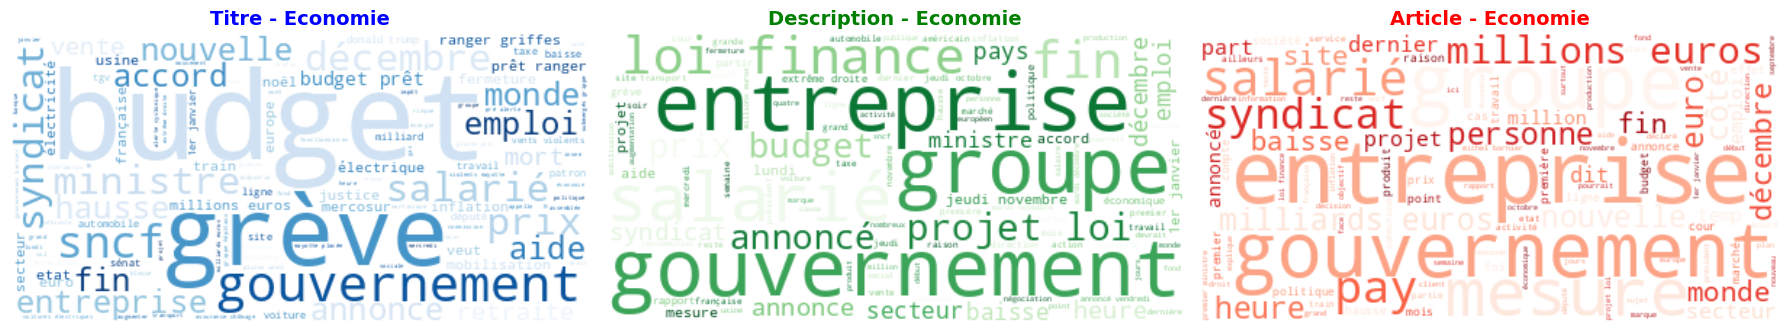

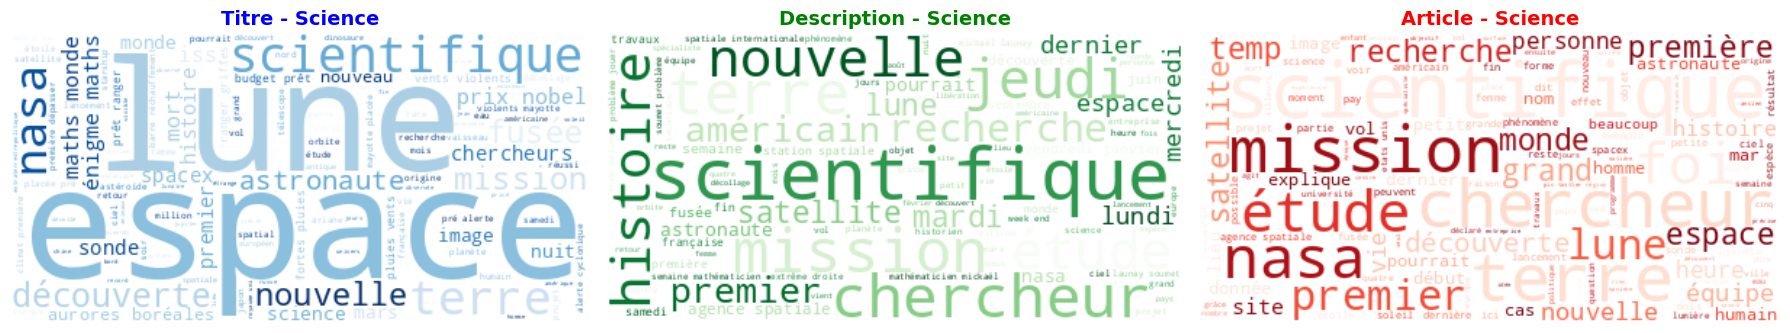

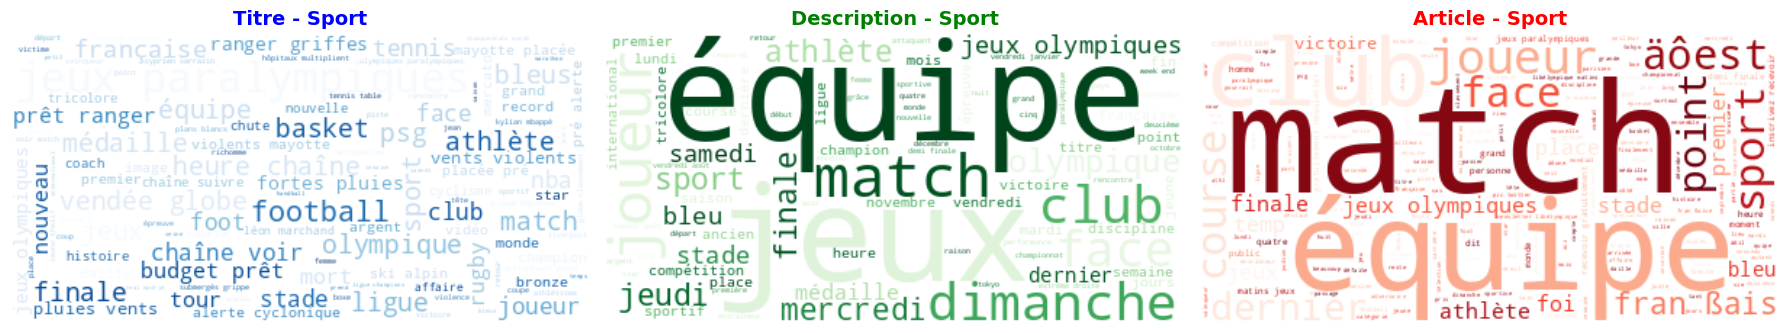

In [ ]:
from wordcloud import WordCloud

def generate_wordclouds(df, type_article):
    # Création des wordclouds
    wordcloud_titre = WordCloud(
        background_color="white", colormap="Blues").generate(' '.join(df['Tokens_Titre'].sum()))

    wordcloud_description = WordCloud(
        background_color="white", colormap="Greens").generate(' '.join(df['Tokens_Description'].sum()))

    wordcloud_article = WordCloud(
        background_color="white", colormap="Reds").generate(' '.join(df['Tokens_Article'].sum()))

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(wordcloud_titre, interpolation="bilinear")
    axes[0].axis("off")
    axes[0].set_title(f"Titre - {type_article}", fontsize=14, fontweight="bold", color="blue")

    axes[1].imshow(wordcloud_description, interpolation="bilinear")
    axes[1].axis("off")
    axes[1].set_title(f"Description - {type_article}", fontsize=14, fontweight="bold", color="green")

    axes[2].imshow(wordcloud_article, interpolation="bilinear")
    axes[2].axis("off")
    axes[2].set_title(f"Article - {type_article}", fontsize=14, fontweight="bold", color="red")

    plt.tight_layout()
    plt.show()

for type_article in df['Type'].unique():
    df_tokens = df[df['Type'] == type_article]
    generate_wordclouds(df_tokens, type_article)

À partir du nuage de mots généré sur les articles, trois grands axes thématiques se dégagent. En économie, les termes récurrents tels que budget,
inflation et gouvernement dans les titres, ainsi que crise, emploi, mesures ou
grève dans les contenus, mettent en lumière des préoccupations liées aux finances publiques, aux politiques économiques et aux tensions sociales. Du côté de la science, les mots-clés comme lune, mars, espace et climat dominent les titres, tandis que les articles évoquent des expériences, découvertes, chercheurs et satellites, révélant un intérêt marqué pour les avancées scientifiques, notamment dans les domaines spatial et environnemental. Enfin, pour le sport, les mots les plus fréquents — JO, Paris, 2024 et football — couplés à des termes comme match, victoire, compétition et athlètes, traduisent une forte couverture médiatique autour des Jeux Olympiques et des grands événements sportifs.

# Vectorisation TF-IDF des titres, descriptions et articles

Applique TF-IDF sur chaque élément de l’article.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Concaténez les tokens filtrés en une seule chaîne de caractères
df['Tokens_Titre'] = df['Tokens_Titre'].apply(lambda x: ' '.join(x))
df['Tokens_Description'] = df['Tokens_Description'].apply(lambda x: ' '.join(x))
df['Tokens_Article'] = df['Tokens_Article'].apply(lambda x: ' '.join(x))

In [ ]:
# Vectorisation TF-IDF
vec = TfidfVectorizer(stop_words=list(stop_words), ngram_range=(1, 1))
X_Titre = vec.fit_transform(df['Tokens_Titre'])
y_Titre = df['Type']

# Divisez les données en ensembles d'entraînement et de test
X_train_Titre, X_test_Titre, y_train_Titre, y_test_Titre = train_test_split(X_Titre, y_Titre, test_size=0.3, random_state=42)

# Encodage des labels
encoder = LabelEncoder()
y_train_Titre = encoder.fit_transform(y_train_Titre)
y_test_Titre = encoder.transform(y_test_Titre)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['lorsqu'] not in stop_words.
  warnings.warn(


In [ ]:
# Concaténation du titre et de la description
df['Tokens_Titre_Desc'] = df['Tokens_Titre'] + " " + df['Tokens_Description']

# Vectorisation TF-IDF
vec = TfidfVectorizer(stop_words=list(stop_words), ngram_range=(1, 1))
X_Titre_Desc = vec.fit_transform(df['Tokens_Titre_Desc'])
y_Titre_Desc = df['Type']

X_train_Titre_Desc, X_test_Titre_Desc, y_train_Titre_Desc, y_test_Titre_Desc = train_test_split(
    X_Titre_Desc, y_Titre_Desc, test_size=0.3, random_state=42)

encoder = LabelEncoder()
y_train_Titre_Desc = encoder.fit_transform(y_train_Titre_Desc)
y_test_Titre_Desc = encoder.transform(y_test_Titre_Desc)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['lorsqu'] not in stop_words.
  warnings.warn(


In [ ]:
# Concaténation du titre, de la description et de l’article entier
df['Tokens_Titre_Desc_Article'] = df['Tokens_Titre'] + " " + df['Tokens_Description'] + " " + df['Tokens_Article']

# Vectorisation TF-IDF
vec = TfidfVectorizer(stop_words=list(stop_words), ngram_range=(1, 1))
X_Titre_Desc_Article = vec.fit_transform(df['Tokens_Titre_Desc_Article'])
y_Titre_Desc_Article = df['Type']

X_train_Titre_Desc_Article, X_test_Titre_Desc_Article, y_train_Titre_Desc_Article, y_test_Titre_Desc_Article = train_test_split(
    X_Titre_Desc_Article, y_Titre_Desc_Article, test_size=0.3, random_state=42)

encoder = LabelEncoder()
y_train_Titre_Desc_Article = encoder.fit_transform(y_train_Titre_Desc_Article)
y_test_Titre_Desc_Article = encoder.transform(y_test_Titre_Desc_Article)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['lorsqu'] not in stop_words.
  warnings.warn(


# Entraînement et évaluation des modèles de classification

Définit une fonction pour entraîner des modèles et visualiser leurs performances.

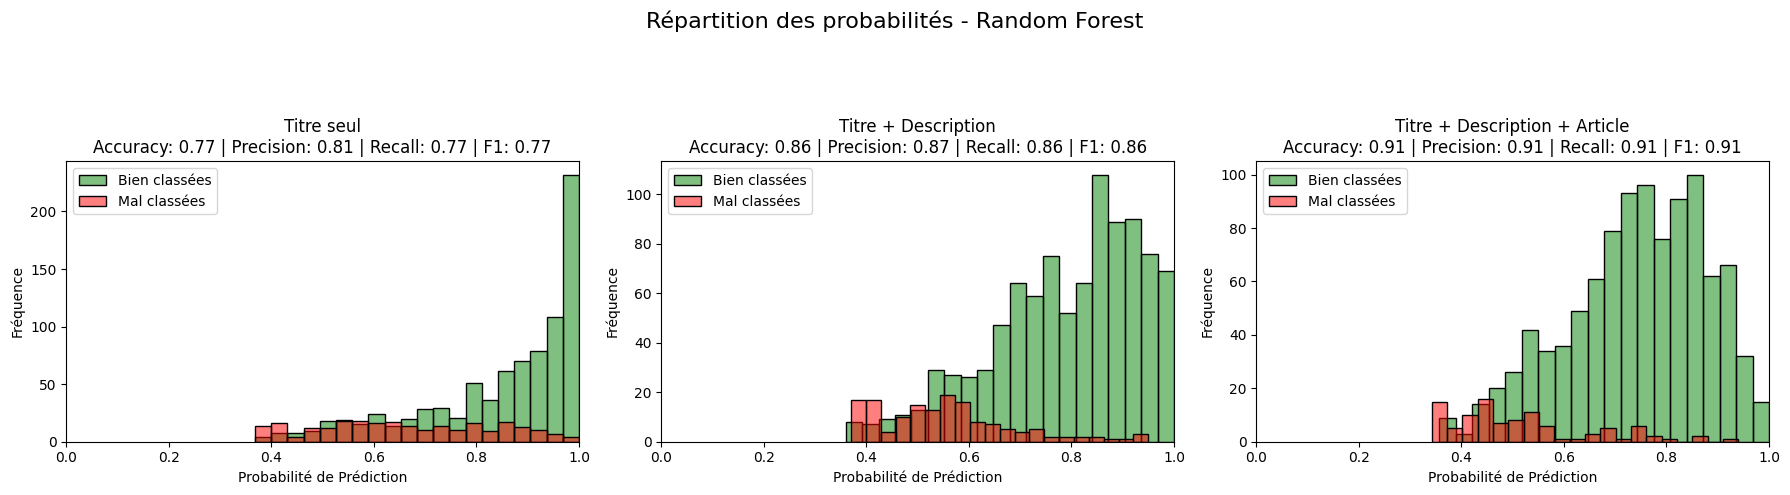

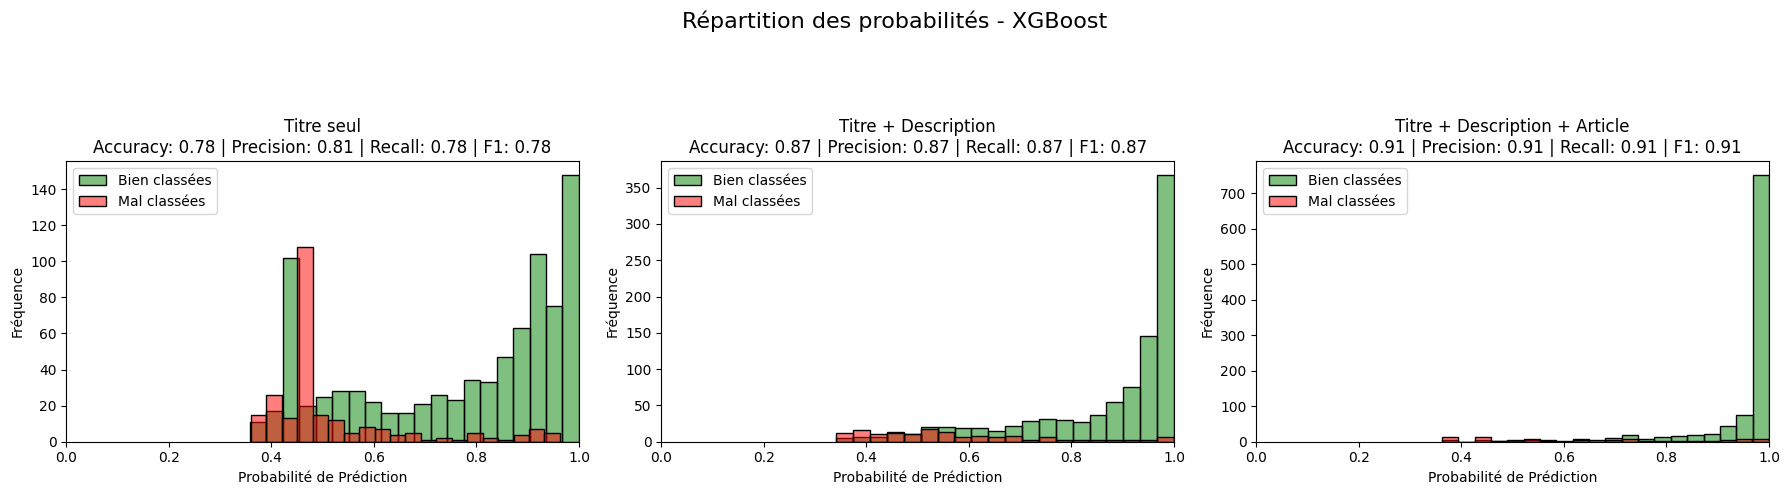

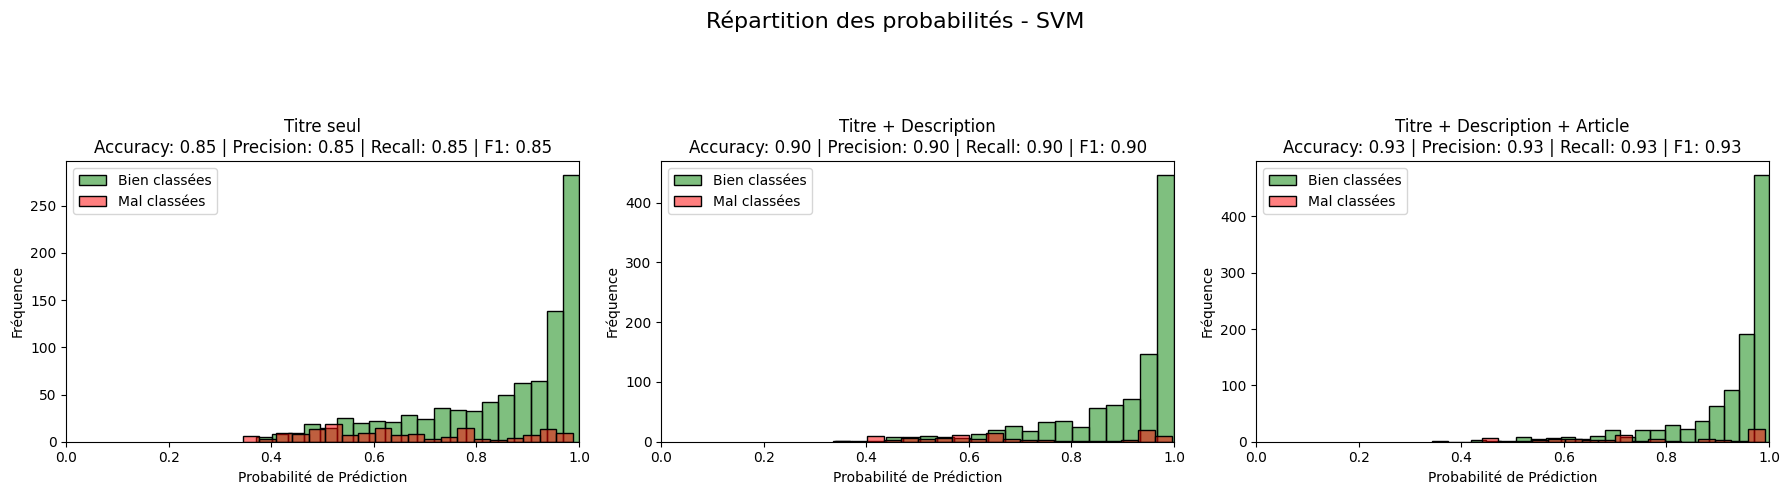

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

def evaluate_model(X_train_list, X_test_list, y_train_list, y_test_list, model, model_name):
    approches = ["Titre seul", "Titre + Description", "Titre + Description + Article"]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"Répartition des probabilités - {model_name}", fontsize=16)

    for i, (X_train, X_test, y_train, y_test, approche) in enumerate(zip(X_train_list, X_test_list, y_train_list, y_test_list, approches)):

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)


        if hasattr(model, "predict_proba"):
            y_proba_max = model.predict_proba(X_test).max(axis=1)
            Bien_classees = y_proba_max[y_pred == y_test]
            Mal_classees = y_proba_max[y_pred != y_test]

            sns.histplot(Bien_classees, bins=20, color="green", alpha=0.5, ax=axes[i], label="Bien classées")
            sns.histplot(Mal_classees, bins=20, color="red", alpha=0.5, ax=axes[i], label="Mal classées")

            title = (f"\n\n{approche}\n"
                     f"Accuracy: {accuracy:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}")
            axes[i].set_title(title)
            axes[i].set_xlabel("Probabilité de Prédiction")
            axes[i].set_ylabel("Fréquence")
            axes[i].set_xlim(0, 1)
            axes[i].legend()
        else:
            # Pas de predict_proba : afficher les métriques dans un simple texte
            axes[i].text(0.5, 0.5, f"{approche}\nAccuracy: {accuracy:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1: {f1:.2f}",
                         ha='center', va='center', fontsize=12)
            axes[i].set_axis_off()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Définition des modèles
models = {
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    "SVM": SVC(kernel='linear', probability=True)
}

# Listes des données d'entraînement et de test
X_train_list = [X_train_Titre, X_train_Titre_Desc, X_train_Titre_Desc_Article]
X_test_list = [X_test_Titre, X_test_Titre_Desc, X_test_Titre_Desc_Article]
y_train_list = [y_train_Titre, y_train_Titre_Desc, y_train_Titre_Desc_Article]
y_test_list = [y_test_Titre, y_test_Titre_Desc, y_test_Titre_Desc_Article]

# Évaluation pour chaque modèle
for name, model in models.items():
    evaluate_model(X_train_list, X_test_list, y_train_list, y_test_list, model, name)


* Les articles bien classés ont une probabilité de prédiction plus concentrée
autour de 1.

* Les articles mal classés ont des probabilités plus dispersées, souvent proches
de 0.5.

* Avec XGBoost, la distinction entre classes est plus marquée

* L’accroissement du contexte textuel est **le facteur déterminant** des performances, bien plus que le choix du modèle

* F1 est quasiment égal à Accuracy dans tous les cas → les classes sont sans doute équilibrées, mais F1 reste préférable car il capture mieux les écarts en cas de déséquilibre.

* Les différences entre les modèles s’estompent à mesure que le texte s’enrichit : preuve que les données dominent la performance, pas l’algorithme.



In [ ]:
from joblib import dump
#Sauvegarde le modèle SVM
dump(models["SVM"], "svm_model.joblib")

['svm_model.joblib']